# 課題4: サッカーの試合における結果の予測

過去の試合データを使って、試合の結果を予測する。

## 1. 必要なモジュールの読み込み

In [1]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import statsmodels.formula.api as smf
import statsmodels.api as sm

%matplotlib inline

## 2. データの読み込み

データはdatasetフォルダ直下にある"J1_data.csv"を使用します。

このデータセットはFootball-Data.co.jp (http://www.football-data.co.uk/japan.php) から引用したものを加工しています。

In [2]:
# データを読み込んで変数 data に格納
data = pd.read_csv('J1_data.csv')

In [3]:
# データの最初の5行だけ表示
data.head()

,Home,Away,Home_Goals,Away_Goals
0,G-Osaka,Kobe,2,3
1,Hiroshima,Urawa,1,0
2,Nagoya,Shimizu,1,0
3,Sagan Tosu,C-Osaka,0,0
4,Sapporo,Iwata,0,0


In [4]:
# Homeチームのゴール数の平均と, Awayチームのゴール数の平均を計算して表示
print(data.describe())

        Home_Goals   Away_Goals
count  2140.000000  2140.000000
mean      1.417757     1.253271
std       1.254916     1.133602
min       0.000000     0.000000
25%       0.000000     0.000000
50%       1.000000     1.000000
75%       2.000000     2.000000
max       7.000000     8.000000


## 3. データ概要の把握

先ほどの「ゴールの平均」を見ると、どうやらHomeチームとAwayチームで得点に差がありそうです。ヒストグラムを作図して詳細を確認してみましょう。

(array([24., 35.,  0., 43.,  0.,  9.,  6.,  0.,  0.,  3.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <a list of 10 Patch objects>)

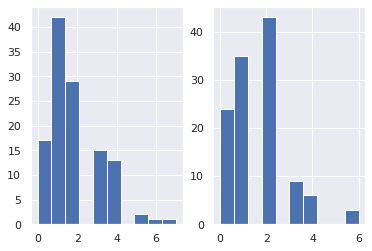

In [5]:
# プロットエリアを2つに分け、Urawaに関して「Homeで試合をしたときの得点のヒストグラム」と「Awayで試合をしたときの得点のヒストグラム」を表示
# なお、ヒストグラムの表示には Matplotlib の hist を使い、figureで2つのグラフを「並べて」表示すること。
# ※ histの詳細： https://matplotlib.org/2.2.2/api/_as_gen/matplotlib.pyplot.hist.html

urawa_home = data.query("Home == 'Urawa'")
urawa_away = data.query("Away == 'Urawa'")
y1 = urawa_home['Home_Goals']
y2 = urawa_away['Away_Goals']
fig = plt.figure()

sp1 = fig.add_subplot(1, 2, 1)
sp1.hist(y1)
sp2 = fig.add_subplot(1, 2, 2)
sp2.hist(y2)

(array([27., 39.,  0., 26.,  0.,  9.,  0.,  0.,  0.,  1.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <a list of 10 Patch objects>)

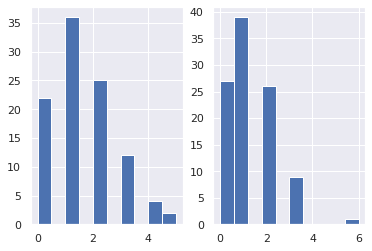

In [6]:
# もう1つ、どこか違うチームをピックアップして、同様に
# 「Homeで試合をしたときの得点のヒストグラム」と「Awayで試合をしたときの得点のヒストグラム」を表示
nagoya_home = data.query("Home == 'Nagoya'")
nagoya_away = data.query("Away == 'Nagoya'")
y1 = nagoya_home['Home_Goals']
y2 = nagoya_away['Away_Goals']
fig = plt.figure()

sp1 = fig.add_subplot(1, 2, 1)
sp1.hist(y1)
sp2 = fig.add_subplot(1, 2, 2)
sp2.hist(y2)

## 4. モデルの作成

2通りのモデルを作成し、AICを確認。

In [7]:
# 説明変数：Away_Goals、HomeとAwayを指定し、ゴール数の予測に適切な確率分布で一般化線形モデルを構築し、AICを算出
model_1 = smf.glm('Home_Goals ~ Away_Goals+Home+Away', data=data, family=sm.families.Poisson()).fit()

In [8]:
# 説明変数：HomeとAway_Goalsを指定し、ゴール数の予測に適切な確率分布で一般化線形モデルを構築し、AICを算出
model_2 = smf.glm('Home_Goals ~ Home+Away_Goals', data=data, family=sm.families.Poisson()).fit()

In [9]:
# 上記2つのモデルを比較し、選択すべき最適なモデルについて詳細を表示
print('Model-1:',model_1.aic.round(3))
print('Model-2:',model_2.aic.round(3))

Model-1: 6448.858
Model-2: 6472.639


In [10]:
# Home: Urawa, Away: KashimaでAwayのチームが0得点だった場合のHomeの得点を予測
pred = model_1.predict(pd.DataFrame(data ={'Home':'Urawa','Away':'Kashima','Away_Goals':0},index = ['Urawa:']))
print(pred)

Urawa:    1.575325
dtype: float64


In [11]:
# Home: Urawa, Away: KashimaでAwayのチームが2得点だった場合のHomeの得点を予測
pred = model_1.predict(pd.DataFrame(data ={'Home':'Urawa','Away':'Kashima','Away_Goals':2},index = ['Urawa:']))
print(pred)

Urawa:    1.730129
dtype: float64


## 5. シミュレーション

Homeの点数の予測値は、Awayの点数によって変わる

Awayの得点は、これまでのAwayでの得点平均をlambda（λ：強度）とするポアソン分布に従うため、

ポアソン分布から乱数を発生させ、その結果からHomeの得点を予測する。

In [12]:
# 今回はKashimaがAwayですので、Kashimaの　Awayでの得点平均を計算
kashima_away = data.query("Away == 'Kashima'")
y3 = kashima_away['Away_Goals']
x1 = np.mean(y3)
print(x1)

1.6363636363636365


[0 5 1 0 0 1 1 1 3 1 0 2 3 0 1 1 1 2 2 3 2 5 1 0 2 4 2 2 3 3 1 1 2 1 1 2 1
 2 0 1 0 4 1 2 1 1 1 2 0 2 3 1 2 0 3 1 2 2 1 4 3 1 1 5 2 1 5 0 1 0 1 0 0 1
 1 1 0 2 1 3 1 4 2 2 2 2 2 5 4 2 3 2 2 2 1 8 0 2 2 1]


(array([16., 34., 29., 10.,  5.,  5.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20.]),
 <a list of 20 Patch objects>)

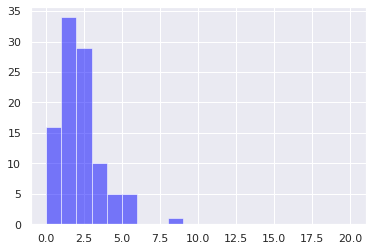

In [13]:
# 上記で求めた平均=lambda(強度：λ)としたポアソン分布から乱数を100個発生させる。
# 参考：https://docs.scipy.org/doc/numpy-1.14.2/reference/generated/numpy.random.poisson.html
list_away = []
x2 = np.random.poisson(lam=x1, size=100)
list_away.append(x2)
print(x2)
plt.hist(x2, label='$\lambda$=1', bins=20, range = (0,20), alpha = 0.5, color='blue')

In [14]:
# Awayの得点よりHomeの得点を予測
list_home = []
for i in range(100):
    pred = model_1.predict(pd.DataFrame(data ={'Home':'Urawa','Away':'Kashima','Away_Goals':x2}))
list_home.append(pred)
arr_list_home = np.array(list_home)
print(arr_list_home)

[[1.57532506 1.99131975 1.6509136  1.57532506 1.57532506 1.6509136
  1.6509136  1.6509136  1.81314557 1.6509136  1.57532506 1.73012909
  1.81314557 1.57532506 1.6509136  1.6509136  1.6509136  1.73012909
  1.73012909 1.81314557 1.73012909 1.99131975 1.6509136  1.57532506
  1.73012909 1.90014541 1.73012909 1.73012909 1.81314557 1.81314557
  1.6509136  1.6509136  1.73012909 1.6509136  1.6509136  1.73012909
  1.6509136  1.73012909 1.57532506 1.6509136  1.57532506 1.90014541
  1.6509136  1.73012909 1.6509136  1.6509136  1.6509136  1.73012909
  1.57532506 1.73012909 1.81314557 1.6509136  1.73012909 1.57532506
  1.81314557 1.6509136  1.73012909 1.73012909 1.6509136  1.90014541
  1.81314557 1.6509136  1.6509136  1.99131975 1.73012909 1.6509136
  1.99131975 1.57532506 1.6509136  1.57532506 1.6509136  1.57532506
  1.57532506 1.6509136  1.6509136  1.6509136  1.57532506 1.73012909
  1.6509136  1.81314557 1.6509136  1.90014541 1.73012909 1.73012909
  1.73012909 1.73012909 1.73012909 1.99131975 1.90

In [21]:
# Homeチームの得点が上回っているデータの個数を計算することで「Homeのチームが勝つ確率」を算出して、表示
data_bool = arr_list_home > list_away
print(data_bool.sum())

50
